In [15]:
import gzip
import numpy as np
import ast  # To safely evaluate string representations of lists
import matplotlib.pyplot as plt

def find_comma_idx(string, comma_number):
    count = 0
    for i, char in enumerate(string):
        if char == ',':
            count += 1
            if count == comma_number:
                return i
    return -1  # If there's no comma_number'th comma

def plot_popularity(products_path, label, example_to_plot, layer_to_plot, group_to_plot):
    # Initialize an empty list to hold the NumPy arrays (tensors)  
    rows = []
    groups = set()
    example = 0
    seq_len_prev = None

    # Collect the relevant v-row popularity scores in the relevant text file
    with gzip.open(f'{products_path}/layer{layer_to_plot}_kept_vrow_popularities_generative_decoding.txt.gz', 'rt') as file:
        for line in file:
            # Split the line to extract the list part. Example row:
            # 31,0,100,[4, 0, 1, 0, 4, 4, 4, 4, 3, 1, 0, 2, 3, 1, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 3, 3, 1, 3, 1, 1, 0, 2, 0, 2, 2, 4, 4, 3, 2, 4, 3, 2, 1, 2, 4, 4, 0, 0, 1, 4, 4, 4, 4]
            # parse the prefix of the row (until the third comma) ast.literal_eval(s)
            split_idx = find_comma_idx(line,3)
            layer, group, seq_len = list(map(int,line[:split_idx].split(',')))
            groups.add(group)

            # track the example number. When there is n increment different than 1 or 0: it means that a new example begins
            if seq_len_prev is not None and seq_len-seq_len_prev not in [0,1]:
                example+=1
            seq_len_prev = seq_len

            # Check if the line starts with '<LAYER>,<GROUP>'
            if example == example_to_plot and layer == layer_to_plot and group == group_to_plot:
                # print(example, layer, group, seq_len)
                # Focus on the popularity list (whihch comes after the 3rd comma)
                list_str = line[split_idx+1:]
                # Convert the string representation of the list to an actual list
                row = ast.literal_eval(list_str)
                # Append the to the list
                rows.append(row)
                
    if len(rows) == 0:
        print(f"Error: the required EXAMPLE={example_to_plot} was not found after scanning examples 0 to {example}.")
    else:
        # Create a matrix from the collected popularity scores
        max_llen  = max(len(r) for r in rows)
        row_pads = [[0] * (max_llen - len(r)) for r in rows]
        padded_rows = [r + p for r, p in zip(rows, row_pads)]
        A = np.array(padded_rows)
        prompt_len = A.shape[1] - A.shape[0]
        completion_len = A.shape[0]

        # Create a figure for 2 sub-figures
        plt.close('all')
        fig, ax = plt.subplots(1, 2, layout='constrained', sharex=True, figsize=(10,6)) 
        plt.suptitle(f"HumanEval/{example_to_plot} - LLaMA3-8B (layer {layer_to_plot}, GQA group {group_to_plot} out of [0..{len(groups)-1}]) generated tokens row-stacked\n{label}\n")

        # Subfigure 1 - Create a heatmap of the popularity counters (of the full group) during generation
        im = ax[0].imshow(A, cmap='inferno', interpolation='nearest')
        plt.colorbar(im, ax=ax[0], shrink=0.5, label='popularity: # heads in the group that selected the attention element', location='bottom', orientation='horizontal')
        ax[0].set_title(f"Attention popularity within the group.\nThe rows correspond to {completion_len} completion tokens.\n The preliminary {prompt_len} prompt tokens are not presented")

        sequence_lengths = np.array([len(r) for r in rows])
        kept_vrows = np.count_nonzero(A, axis=1)

        # Subfiure 2 - show kept V-rows
        ax[1].plot(kept_vrows, range(prompt_len, prompt_len + completion_len), color='orange', label='kept')
        ax[1].plot(sequence_lengths, range(prompt_len, prompt_len + completion_len), 'r--', label='total')
        # ax[1].fill_between(range(prompt_len, prompt_len + completion_len), kept_vrows, where=None, interpolate=True, color='orange')
        ax[1].set_title('Number of kept V-rows')

        # show saved V-Rows
        # saved_v_rows = sequence_lengths - kept_vrows
        # ax[1].plot(saved_v_rows, range(prompt_len, prompt_len + completion_len), 'b-', label='removed')
        # ax[1].set_title('Number of saved V-rows')
        # ax[1].set_xlabel('Number of Zero attentions (saved V-rows)')-

        ax[1].set_xlabel('Number of V-rows')
        ax[1].legend()
        ax[1].set_ylabel('Completion Token ID')
        ax[1].invert_yaxis()  # Invert y-axis to match heatmap orientation

        # Save the image
        sanitized_label = label.translate(str.maketrans({"+":"", " ":"-", "=":"-", "+":"-","+":"-"}))
        filename_wo_extension = f'../figures/vrow_popularity/heatmap_{sanitized_label}_e{example_to_plot}_l{layer_to_plot}_g{group_to_plot}'
        plt.savefig(f'{filename_wo_extension}.png', dpi=300)  # You can change the filename and format (e.g., .jpg, .pdf)
        plt.savefig(f'{filename_wo_extension}.eps', dpi=300)  # You can change the filename and format (e.g., .jpg, .pdf)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


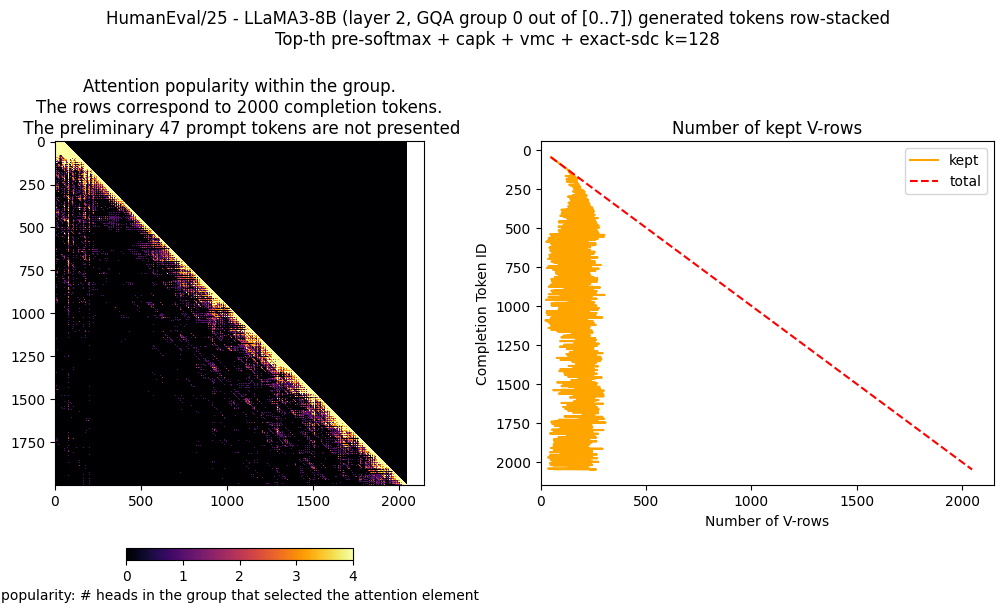

In [16]:
# path to the products directory/timestamp
# PATH="../products/2024-12-17_18-54-50_993539"    # 'Top-th pre-softmax + vmc + exact-sdc', k=32
# PATH="../experiments/10-acc-size-tradeoff/products/2024-12-13_17-36-29_806131"    # 'Top-th pre-softmax + vmc + exact-sdc', k=32
# PATH="../experiments/10-acc-size-tradeoff/products/2024-12-13_17-14-13_044280"    # 'Top-th pre-softmax + vmc + exact-sdc', k=128
# PATH="../experiments/10-acc-size-tradeoff/products/2024-12-11_14-11-48_484564"    # 'Top-k pre-softmax + vmc + exact-sdc', k=32
# PATH="../experiments/10-acc-size-tradeoff/products/2024-12-11_22-58-24_689703"    # 'Top-k pre-softmax + vmc + exact-sdc',  k=128
# PATH='../experiments/10-acc-size-tradeoff/products/2024-12-13_17-14-13_044280'    #  'Top-th pre-softmax + vmc + exact-sdc', k=128
PATH,LABEL='../experiments/10-acc-size-tradeoff/products/2024-12-12_06-52-19_767876','Top-th pre-softmax + capk + vmc + exact-sdc k=128'

EXAMPLE=25 # number of the test example to plot (0 is the first example)
LAYER=2 # choose a layer to focus on
GROUP=0 # GQA group of query heads

plot_popularity(PATH, LABEL, EXAMPLE, LAYER, GROUP)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


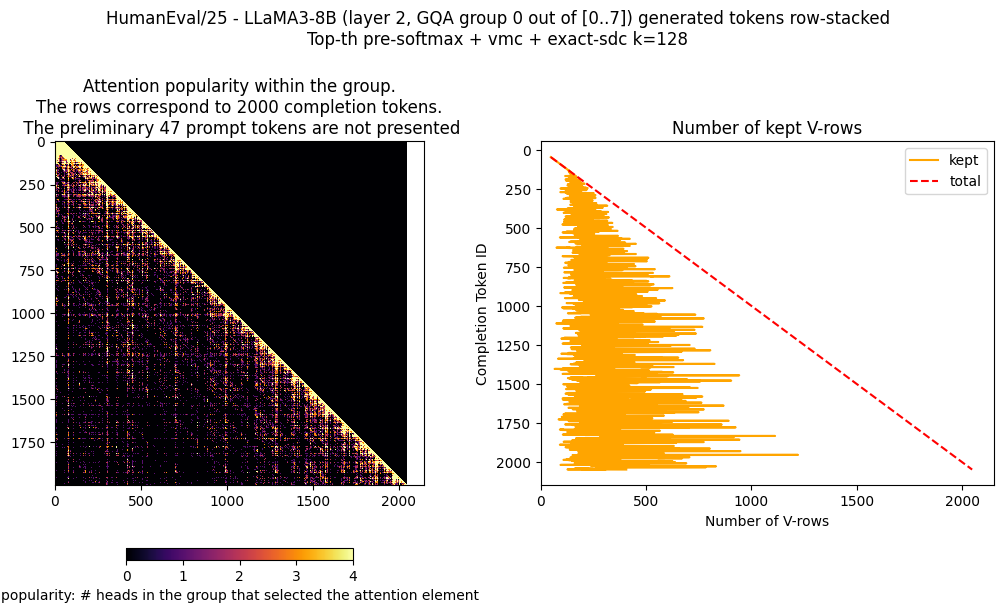

In [17]:
PATH,LABEL="../experiments/10-acc-size-tradeoff/products/2024-12-13_17-14-13_044280","Top-th pre-softmax + vmc + exact-sdc k=128"
EXAMPLE=25 # number of the test example to plot (0 is the first example)
LAYER=2 # choose a layer to focus on
GROUP=0 # GQA group of query heads

plot_popularity(PATH, LABEL, EXAMPLE, LAYER, GROUP)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


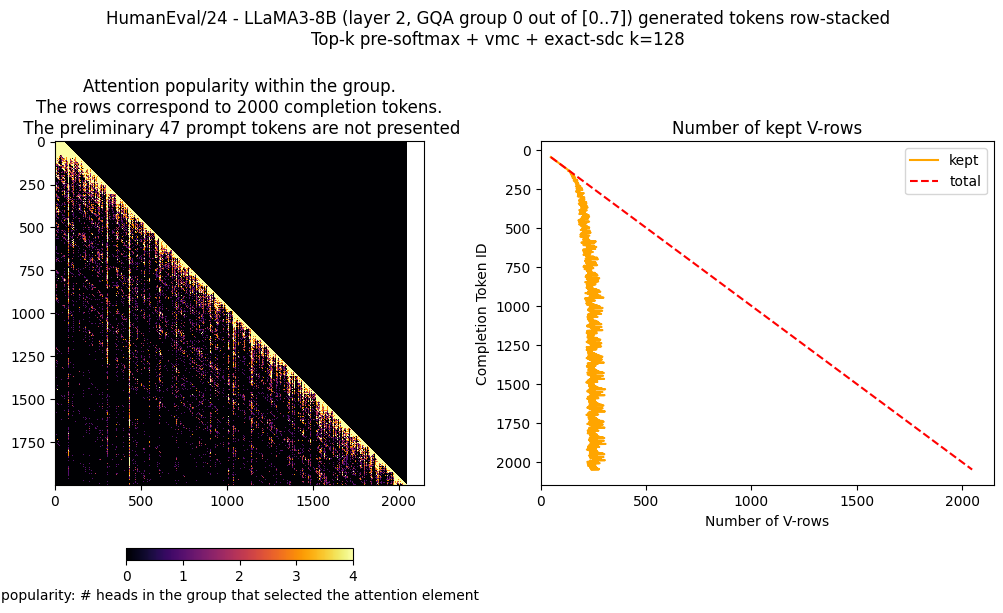

In [18]:
PATH,LABEL="../experiments/10-acc-size-tradeoff/products/2024-12-11_22-58-24_689703",'Top-k pre-softmax + vmc + exact-sdc k=128'
EXAMPLE=24 # number of the test example to plot (0 is the first example)
LAYER=2 # choose a layer to focus on
GROUP=0 # GQA group of query heads

plot_popularity(PATH, LABEL, EXAMPLE, LAYER, GROUP)